# ***Training Support Vector Machines for Multiclass Classification ***

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'diet.csv', 'labs.csv.zip', 'medications.csv.zip', 'train.csv', 'examination.csv', 'demographic.csv.zip', 'diet.csv.zip', 'demographic.csv', 'examination.csv.zip', 'questionnaire.csv', 'labs.csv', 'medications.csv', 'questionnaire.csv.zip']


### Load the Train and Test set

In [3]:
train = shuffle(pd.read_csv("input/train.csv"))
test = shuffle(pd.read_csv("input/test.csv"))

### Check for missing values in the dataset

In [4]:
print("Any missing sample in training set:",train.isnull().values.any())
print("Any missing sample in test set:",test.isnull().values.any(), "\n")


Any missing sample in training set: False
Any missing sample in test set: False 



### Frequency Distribution of the Outome

In [5]:
#Frequency distribution of classes"
train_outcome = pd.crosstab(index=train["Activity"],  # Make a crosstab
                              columns="count")      # Name the count column

train_outcome


col_0,count
Activity,
LAYING,1407
SITTING,1286
STANDING,1374
WALKING,1226
WALKING_DOWNSTAIRS,986
WALKING_UPSTAIRS,1073


### Visualizing Outcome Distribution 

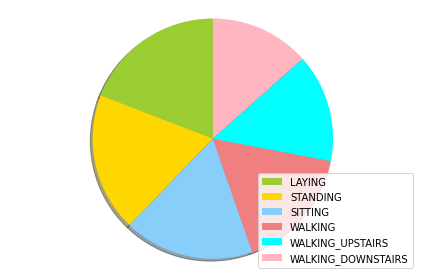

In [6]:
# Visualizing Outcome Distribution 
temp = train["Activity"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

#df.plot(kind='pie',labels='labels',values='values', title='Activity Ditribution',subplots= "True")

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()


### Normalize the Predictor(Feature Set) for SVM training 

In [7]:
# Seperating Predictors and Outcome values from train and test sets
X_train = pd.DataFrame(train.drop(['Activity','subject'],axis=1))
Y_train_label = train.Activity.values.astype(object)
X_test = pd.DataFrame(test.drop(['Activity','subject'],axis=1))
Y_test_label = test.Activity.values.astype(object)

# Dimension of Train and Test set 
print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")

# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

# encoding test labels 
encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

#Total Number of Continous and Categorical features in the training set
num_cols = X_train._get_numeric_data().columns
print("Number of numeric features:",num_cols.size)
#list(set(X_train.columns) - set(num_cols))


names_of_predictors = list(X_train.columns.values)

# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dimension of Train set (7352, 561)
Dimension of Test set (2947, 561) 

Number of numeric features: 561


### Hyperparameter tuning using grid search and cross validation

In [8]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


### Training SVM model using radial kernel

In [9]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, Y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

### Confusion Matrix  and Accuracy Score 

In [10]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

Best score for training data: 0.9891182360095636 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



In [11]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
print(confusion_matrix(Y_test_label,Y_pred_label))
print("\n")
print(classification_report(Y_test_label,Y_pred_label))

print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))

svm_model.score

[[537   0   0   0   0   0]
 [  3 440  47   0   0   1]
 [  0  13 519   0   0   0]
 [  0   0   0 486   4   6]
 [  0   0   0   6 389  25]
 [  0   0   0  15   2 454]]


                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.98      0.97       496
WALKING_DOWNSTAIRS       0.98      0.93      0.95       420
  WALKING_UPSTAIRS       0.93      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.958602


<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])>